In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
from datetime import datetime
from tqdm import tqdm
import cv2

print('tf.__version__', tf.__version__)
print('cv2.__version__', cv2.__version__)

tf.__version__ 2.17.1
cv2.__version__ 4.10.0


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os

In [3]:
# Image size for resizing
IMAGE_SIZE = (256, 256)
CHECKPOINT_DIR = '/kaggle/input/segmentationmodels8_roadseg/tensorflow2/default/1/'

EPOCHS = 5

# Define directories for logging and saving
LOG_DIR = '/kaggle/working/logs'
CHECKPOINT_DIR = '/kaggle/working/checkpoints'

# Dataset directories
class_dir = {
    'asphalt': [
        '/kaggle/input/road-traversing-knowledge-rtk-dataset/RTK_Dataset/asphalt/asphaltBad',
        '/kaggle/input/road-traversing-knowledge-rtk-dataset/RTK_Dataset/asphalt/asphaltGood',
        '/kaggle/input/road-traversing-knowledge-rtk-dataset/RTK_Dataset/asphalt/asphaltRegular'
    ],
    'paved': [
        '/kaggle/input/road-traversing-knowledge-rtk-dataset/RTK_Dataset/paved/pavedBad',
        '/kaggle/input/road-traversing-knowledge-rtk-dataset/RTK_Dataset/paved/pavedRegular'
    ],
    'unpaved': [
        '/kaggle/input/road-traversing-knowledge-rtk-dataset/RTK_Dataset/upaved/unpavedBad',
        '/kaggle/input/road-traversing-knowledge-rtk-dataset/RTK_Dataset/upaved/unpavedRegular'
    ]
}

In [4]:
# Custom DenseNet121 model
def build_densenet121_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False  # Freeze base model layers
    
    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')  # 3 classes: asphalt, paved, unpaved or bad, good, regular
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
def preprocess_image(img_path):
    img = load_img(img_path, target_size=IMAGE_SIZE)
    img = img_to_array(img) / 255.0
    return img

In [6]:
# Load the dataset and segment images
def load_and_segment_data(class_dirs):
    images = []
    labels = []
    label_mapping = {'asphalt': 0, 'paved': 1, 'unpaved': 2}

    # Iterate through the class directories
    for label, dirs in tqdm(class_dirs.items(), desc="Classes", leave=False):
        for dir in tqdm(dirs, desc="Directories", leave=False):
            for img_name in tqdm(os.listdir(dir), desc="Images", leave=False):
                img_path = os.path.join(dir, img_name)
                #segmented_image = load_and_predict(img_path)  # Use previously defined function
                no_segmented_image = preprocess_image(img_path)
                
                images.append(no_segmented_image)  # Assuming this is for segmented data
                labels.append(label_mapping[label])

    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

In [7]:
# Load and preprocess images after segmentation
X, y = load_and_segment_data(class_dir)

# Encode labels (asphalt, paved, unpaved)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


Directories:   0%|          | 0/3 [00:00<?, ?it/s]

Images:   0%|          | 0/464 [00:00<?, ?it/s]

Images:   2%|▏         | 7/464 [00:00<00:07, 62.41it/s]

Images:   4%|▍         | 18/464 [00:00<00:05, 88.52it/s]

Images:   6%|▋         | 29/464 [00:00<00:05, 83.81it/s]

Images:   8%|▊         | 38/464 [00:00<00:04, 85.98it/s]

Images:  10%|█         | 47/464 [00:00<00:04, 87.03it/s]

Images:  12%|█▏        | 57/464 [00:00<00:04, 89.14it/s]

Images:  14%|█▍        | 66/464 [00:00<00:04, 81.88it/s]

Images:  16%|█▌        | 75/464 [00:00<00:04, 80.72it/s]

Images:  18%|█▊        | 85/464 [00:01<00:04, 84.15it/s]

Images:  20%|██        | 95/464 [00:01<00:04, 88.27it/s]

Images:  22%|██▏       | 104/464 [00:01<00:04, 87.45it/s]

Images:  25%|██▍       | 114/464 [00:01<00:03, 89.67it/s]

Images:  27%|██▋       | 124/464 [00:01<00:03, 90.38it/s]

Images:  29%|██▉       | 135/464 [00:01<00:03, 95.79it/s]

Images:  31%|███▏      | 146/464 [00:01<00:03, 97.56it/s]

Images:  34%|███▎      | 

In [8]:
# Build model
model = build_densenet121_model()
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 8, 8, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,563,843 (28.85 MB)

 Trainable params: 526,339 (2.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [9]:
X_train.shape, X_val.shape, X_test.shape

((3684, 256, 256, 3), (410, 256, 256, 3), (1024, 256, 256, 3))

In [10]:
# Create directories if they don't exist
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# TensorBoard callback
tensorboard_cb = TensorBoard(log_dir=LOG_DIR, histogram_freq=1)

# Model checkpoint callback
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, 'best_model_road_type.weights.h5'),
    save_weights_only=True,   # Change to False to save the entire model
    save_best_only=True,
    monitor='val_loss',        # Monitor validation loss
    mode='min',                # Save the model with minimum validation loss
    verbose=1
)

# Training the model
history = model.fit(
    X_train, 
    y_train, 
    epochs=EPOCHS, 
    validation_data=(X_val, y_val),
    callbacks=[tensorboard_cb, checkpoint_cb]
)

print(f"Training complete. Checkpoints saved in {CHECKPOINT_DIR}")

Epoch 1/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8185 - loss: 0.5683
Epoch 1: val_loss improved from inf to 0.11723, saving model to /kaggle/working/checkpoints/best_model_road_type.weights.h5
116/116 ━━━━━━━━━━━━━━━━━━━━ 70s 379ms/step - accuracy: 0.8192 - loss: 0.5662 - val_accuracy: 0.9610 - val_loss: 0.1172
Epoch 2/5
115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9745 - loss: 0.0958
Epoch 2: val_loss improved from 0.11723 to 0.06226, saving model to /kaggle/working/checkpoints/best_model_road_type.weights.h5
116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.9745 - loss: 0.0956 - val_accuracy: 0.9829 - val_loss: 0.0623
Epoch 3/5
115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9910 - loss: 0.0406
Epoch 3: val_loss improved from 0.06226 to 0.03865, saving model to /kaggle/working/checkpoints/best_model_road_type.weights.h5
116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.9910 - loss: 0.0406 - val_accuracy: 0.9878 - val_loss: 0.0386
E

In [11]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print('Test Loss:',test_loss,'\nTest Accuracy:', test_accuracy)

32/32 - 3s - 97ms/step - accuracy: 0.9941 - loss: 0.0158
Test Loss: 0.015830403193831444 
Test Accuracy: 0.994140625


In [12]:
from sklearn.metrics import classification_report

# Step 1: Predict labels for the test set
y_pred_probs = model.predict(X_test)  # Predictions are probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Step 2: Compute classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['asphalt', 'paved', 'unpaved']))


32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step
Classification Report:
              precision    recall  f1-score   support

     asphalt       1.00      1.00      1.00       659
       paved       0.97      0.99      0.98        78
     unpaved       1.00      0.99      0.99       287

    accuracy                           0.99      1024
   macro avg       0.99      0.99      0.99      1024
weighted avg       0.99      0.99      0.99      1024



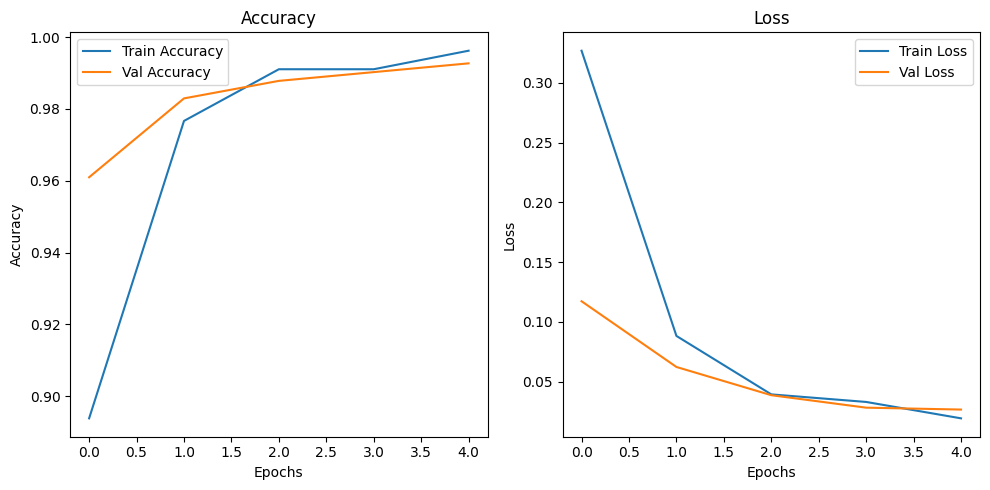

In [13]:
# Plot Accuracy and Loss Graphs
plt.figure(figsize=(10, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()